# Exploratory Data Analysis on Q&A

- Read a qa file
- Clean it
- Analyze questions and clean them
- Get embeddings
- Identify and remove near-duplicates
- Cluster questions
- Keep one question from each cluster 

In [1]:
%load_ext dotenv
%dotenv

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from openai import OpenAI
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
import umap

In [3]:
in_filename = 'data/sleeping_gods_qa.tsv' 
n_sample_questions = 200

In [4]:
# init plotly
init_notebook_mode(connected=True)

In [6]:
qa_df = pd.read_csv(in_filename, sep='\t', na_filter=False)

In [7]:
# show the first 10 rows
qa_df.head(10)

,url,question,answer,manual quote
0,https://boardgamegeek.com/thread/3271748/i-hav...,Can you place 4 damage in a square shaped patt...,4 damage in a square is ok. Place the first on...,
1,,Can you do partial damage to an enemy heart sy...,It's all or nothing.,
2,,Square is ok because one damage is placed next...,A T is allowed. Its even used as a specific ex...,
3,https://boardgamegeek.com/thread/3269600/trave...,"When travelling to new page, does movement sto...",You can continue moving.,
4,https://boardgamegeek.com/thread/3266861/audri...,"But why does it say that ""Audrie's 2nd crew bo...",Some of the crew abilities can be used in comb...,
5,https://boardgamegeek.com/thread/3260955/when-...,When does the fight start?,You can do it up until you look at the enemy c...,
6,https://boardgamegeek.com/thread/3254605/disca...,Can you discard cards during any challenge to ...,"Yes, any player may discard any number of abil...",
7,https://boardgamegeek.com/thread/3253107/zombi...,"So assuming I have $5, I can purchase all 15 f...","Your interpretation sounds right to me, especi...",
8,https://boardgamegeek.com/thread/3250276/when-...,"When doing a challenge, can I not use a crew m...",You can choose to have no crew members partici...,
9,,Can anyone share the damage incurred in case ...,−X health: You must take crew damage. Damage m...,


In [8]:
# fill missing url values from the row above
qa_df['url'] = qa_df['url'].replace('', pd.NA)
qa_df['url'] = qa_df['url'].ffill()
qa_df.head(10)

,url,question,answer,manual quote
0,https://boardgamegeek.com/thread/3271748/i-hav...,Can you place 4 damage in a square shaped patt...,4 damage in a square is ok. Place the first on...,
1,https://boardgamegeek.com/thread/3271748/i-hav...,Can you do partial damage to an enemy heart sy...,It's all or nothing.,
2,https://boardgamegeek.com/thread/3271748/i-hav...,Square is ok because one damage is placed next...,A T is allowed. Its even used as a specific ex...,
3,https://boardgamegeek.com/thread/3269600/trave...,"When travelling to new page, does movement sto...",You can continue moving.,
4,https://boardgamegeek.com/thread/3266861/audri...,"But why does it say that ""Audrie's 2nd crew bo...",Some of the crew abilities can be used in comb...,
5,https://boardgamegeek.com/thread/3260955/when-...,When does the fight start?,You can do it up until you look at the enemy c...,
6,https://boardgamegeek.com/thread/3254605/disca...,Can you discard cards during any challenge to ...,"Yes, any player may discard any number of abil...",
7,https://boardgamegeek.com/thread/3253107/zombi...,"So assuming I have $5, I can purchase all 15 f...","Your interpretation sounds right to me, especi...",
8,https://boardgamegeek.com/thread/3250276/when-...,"When doing a challenge, can I not use a crew m...",You can choose to have no crew members partici...,
9,https://boardgamegeek.com/thread/3250276/when-...,Can anyone share the damage incurred in case ...,−X health: You must take crew damage. Damage m...,


In [41]:
# show the total number of qa pairs, and the number of pairs with a manual quote
print(len(qa_df))
print(qa_df.shape)
print(len(qa_df[qa_df['manual quote'] != '']))

588
(588, 4)
13


In [43]:
# fancy indexing
non_empty_manual_quote = qa_df['manual quote'] != ''
non_empty_manual_quote

0      False
1      False
2      False
3      False
4      False
       ...  
583     True
584    False
585    False
586    False
587    False
Name: manual quote, Length: 588, dtype: bool

In [44]:
# show all rows with a manual quote
qa_df[non_empty_manual_quote]

,url,question,answer,manual quote
18,https://boardgamegeek.com/thread/3248418/if-i-...,"If I equip a weapon to my crew, can I equip ot...","according to rulebook p.29 - not in combat""You...",You can equip this to a crew member (or give i...
24,https://boardgamegeek.com/thread/3222657/ship-...,Ship Action: Can I gain command points (CP) th...,"The rulebook says ""Ship action effects can be ...",Ship action effects can be applied in any orde...
33,https://boardgamegeek.com/thread/3205199/are-t...,Are the rings considered a line?,Assuming you mean the ring binder of the map b...,"Regions are separated by dotted lines, land, t..."
83,https://boardgamegeek.com/thread/3070941/did-w...,Did we win or lose this combat?,"Page 22 (upper left) of the rule book: ""Enemy ...",Enemy Health: Each heart must be covered to de...
126,https://boardgamegeek.com/thread/3012276/do-di...,Do discarded ability cards go to the bottom of...,"Rulebook, p. 10 under Ship Action: ""If the abi...","If the ability deck runs out, shuffle the disc..."
169,https://boardgamegeek.com/thread/2960501/travel,Can effects that change the chance to hit be u...,"Yes: From page 23: “After you draw, you may us...","“After you draw, you may use adventure card an..."
172,https://boardgamegeek.com/thread/2960501/travel,Will the Sea Serpent token follow us even if w...,It will follow you wherever you go. Page 12: ...,“ Hunting Serpent Special Rule: For this event...
470,https://boardgamegeek.com/thread/2605775/syner...,Do synergy tokens stay on character cards afte...,"No.Pg 25 of the main rulebook, ""At the start o...","At the start of each battle, make sure that ea..."
498,https://boardgamegeek.com/thread/2598711/can-y...,Can you however cook right before combat. So a...,"Yes, you can cook right before combat (or righ...","Again page 18, ""You can, however, cook recipes..."
510,https://boardgamegeek.com/thread/2597321/chall...,Can you only add skill to your own crew member...,You can pay command to equip ability cards to ...,"You may spend command at any time, even on oth..."


## Analyze Questions

In [11]:
# get only questions into a separate dataframe
q_df = qa_df[['question']]
q_df.head()

,question
0,Can you place 4 damage in a square shaped patt...
1,Can you do partial damage to an enemy heart sy...
2,Square is ok because one damage is placed next...
3,"When travelling to new page, does movement sto..."
4,"But why does it say that ""Audrie's 2nd crew bo..."


In [12]:
# remove duplicates (shouldn't be many)
q_df = q_df.drop_duplicates()
print(len(q_df))

582


In [13]:
# count the number of words in the question
q_df['word_count'] = q_df['question'].apply(lambda q: len(str(q).split()))
q_df.head()

,question,word_count
0,Can you place 4 damage in a square shaped patt...,21
1,Can you do partial damage to an enemy heart sy...,20
2,Square is ok because one damage is placed next...,41
3,"When travelling to new page, does movement sto...",25
4,"But why does it say that ""Audrie's 2nd crew bo...",14


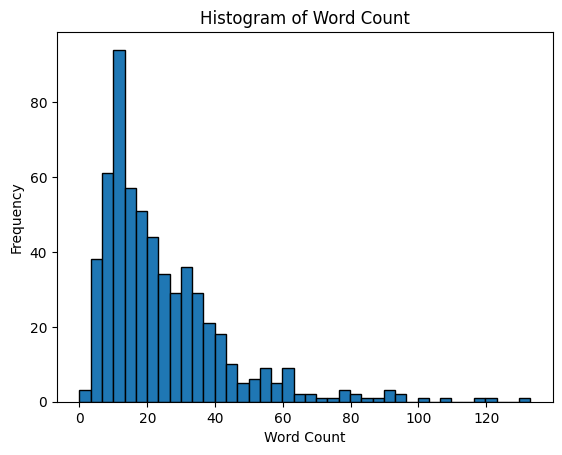

In [14]:
# plot the word counts
q_df['word_count'].plot(kind='hist', bins=40, edgecolor='black')
# Adding labels and title
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
# Show the plot
plt.show()

In [15]:
# review short questions
short_df = q_df[q_df['word_count'] <= 5]
print(len(short_df))
short_df

23


,question,word_count
5,When does the fight start?,5
32,Where does the captain go?,5
49,"Final scoring, which cards?",4
66,Frightened to 0-health character?,4
88,Artifacts - what for.,4
151,Do characters die in battle?,5
152,Can I play solo?,4
164,Is there an official ruling/FAQ?,5
179,Fate Symbols on Ship board?,5
222,What are the coin values?,5


In [16]:
short_df = q_df[q_df['word_count'] < 3]
print(len(short_df))
short_df

1


,question,word_count
449,,0


In [17]:
# review long questions
long_df = q_df[q_df['word_count'] >= 100]
print(len(long_df))
long_df

5


,question,word_count
155,It seems there are some numbered locations tha...,133
220,In the pictured example Player 2 has the above...,117
265,"Thank you, I don't think I explained my questi...",121
306,Let’s say I got an ability card with perceptio...,107
473,Which of these statements is correct:A) Since ...,100


In [18]:
for q, count in zip(long_df['question'], long_df['word_count']):
    print(count)
    print(q)
    print()

133
It seems there are some numbered locations that you can visit again and again. I'm wondering if I'm missing something or if there is something missing with the translation of the game (I have the french edition) because sometimes it doesn't make sense. For instance: on location 6 (p14 of the map book): You find a recently abandonned camp you can either loot or wait for the camper to come back. First time I went there, I waited, the group came back and they were mad at me and I run away with a coin. If I go there a second time, nothing tells me that something has changed. I can just do the same thing again or choose the other option, and the same groupe come back again? That's a bit weird

117
In the pictured example Player 2 has the above Marco and he has a Cunning ability card equipped. If player 1 is captain and a Cunning skill challenge is encountered, Player 2 wishes to participate as well with Marco. We understand you expend one command token to participate in a challenge if y

In [19]:
# remove short questions
q_df = q_df[q_df['word_count'] >= 3]
len(q_df)

581

## Embeddings

In [20]:
embed_filename = in_filename[:-4]+'-embed.tsv'

In [48]:
# get embeddings by calling openai
client = OpenAI()

def get_embedding(text, model='text-embedding-3-large'):
    text = text.replace('\n', ' ')
    return client.embeddings.create(input=[text], model=model).data[0].embedding

q_df['embeddings'] = q_df['question'].apply(lambda q: get_embedding(str(q)))

In [49]:
# save them 
q_df.to_csv(embed_filename, index=False, sep='\t')

In [46]:
# read them back in, and use eval to convert embeddings into a numpy array
# do this to make sure we saved the embeddings correctly
q_df = pd.read_csv(embed_filename, sep='\t')
q_df['embeddings'] = q_df.embeddings.apply(eval)
q_df.head()

,question,word_count,embeddings
0,Can you place 4 damage in a square shaped patt...,21,"[-0.01589909940958023, -0.006159243639558554, ..."
1,Can you do partial damage to an enemy heart sy...,20,"[0.004627369809895754, -0.005235826596617699, ..."
2,Square is ok because one damage is placed next...,41,"[-0.019245339557528496, -0.006209223065525293,..."
3,"When travelling to new page, does movement sto...",25,"[-0.021373728290200233, -0.022455552592873573,..."
4,"But why does it say that ""Audrie's 2nd crew bo...",14,"[-0.005988049320876598, -0.002402470912784338,..."


## Remove near-duplicates

Do this by clustering the embeddings using hierarchal agglomerative clustering and visualize the results to determine a cut-off 

In [47]:
# convert question embeddings to a single numpy array
X = np.array(q_df['embeddings'].tolist())
print(X.shape)

(581, 3072)


In [48]:
# remove questions that are more-similar than this distance threshold
near_dup_threshold = 0.65

In [24]:
# compute the full tree by setting distance_threshold=0
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)

In [25]:
# define plot_dendogram function 
# copied from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
# and modified slightly

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
            counts[i] = current_count
            
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    
    # Plot the corresponding dendrogram)
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
# plot the clusters - image not shown in notebook because github can't display it
plt.figure(figsize=(10,100))
plt.title('Similar Questions')
plot_dendrogram(
    model, 
    truncate_mode=None, 
    color_threshold=near_dup_threshold, 
    orientation='left', 
    labels=q_df['question'].tolist()
)
plt.yticks(fontsize=12)
plt.show()

In [49]:
# cluster the sentences
model = AgglomerativeClustering(distance_threshold=near_dup_threshold, n_clusters=None)
# generate the clusters
q_df['cluster'] = model.fit_predict(X)
# print the number of clusters
print(model.n_clusters_)

562


In [50]:
q_df.head(10)

,question,word_count,embeddings,cluster
0,Can you place 4 damage in a square shaped patt...,21,"[-0.01589909940958023, -0.006159243639558554, ...",10
1,Can you do partial damage to an enemy heart sy...,20,"[0.004627369809895754, -0.005235826596617699, ...",439
2,Square is ok because one damage is placed next...,41,"[-0.019245339557528496, -0.006209223065525293,...",10
3,"When travelling to new page, does movement sto...",25,"[-0.021373728290200233, -0.022455552592873573,...",449
4,"But why does it say that ""Audrie's 2nd crew bo...",14,"[-0.005988049320876598, -0.002402470912784338,...",507
5,When does the fight start?,5,"[-0.0003593567234929651, -0.03567568585276604,...",325
6,Can you discard cards during any challenge to ...,11,"[-0.016855496913194656, -0.027753189206123352,...",557
7,"So assuming I have $5, I can purchase all 15 f...",29,"[-0.014904678799211979, 0.016938546672463417, ...",471
8,"When doing a challenge, can I not use a crew m...",11,"[-0.03352489694952965, -0.028948942199349403, ...",12
9,Can anyone share the damage incurred in case ...,10,"[-0.03843124955892563, 0.031494200229644775, -...",331


In [27]:
# Display rows grouped by cluster
for cluster_id in q_df['cluster'].unique():
    rows = q_df[q_df['cluster'] == cluster_id]
    if len(rows) > 1:
        for q in rows['question']:
            print(q)
        print('---')

Can you place 4 damage in a square shaped pattern? Or would one of these placements be diagonally and not allowed?
Square is ok because one damage is placed next to previous and not diagonally, but now I wonder if 4 damage could be placed as a T shape? After all every damage is next to another but definitely not from previous...
---
When doing a challenge, can I not use a crew member?
Can you do the challenge without choosing any crew member to participate in it?
---
After the ability card is drawn to determine fate for a CHALLENGE can any crew member, including those that have not participated in the challenge originally, spend a command token on an equipped ability card to boost the fate number by 1 if the symbol matches the challenge type?
If no participating crew have an ability card with cunning can a non participating crew member spend 1 command on an equipped ability card to boost the fate draw by 1?
---
Can you activate abilities on other player's Crew or Crew Ability Cards?
Ac

In [28]:
# Keep the longest question for each cluster
def find_longest_in_cluster(df):
    longest_ix = df['question'].str.len().idxmax()
    return df.loc[longest_ix]

q_df = q_df.groupby('cluster').apply(find_longest_in_cluster, include_groups=False).reset_index(drop=True)
print(len(q_df))
q_df.head()

562


,question,word_count,embeddings
0,"During a challenge, is it only crew members wh...",54,"[-0.015484137460589409, -0.015149465762078762,..."
1,Can the non-active player use abilities (both ...,46,"[-0.029526829719543457, -0.0025611373130232096..."
2,Does this mean you can ONLY discard one equipp...,15,"[-0.05306801199913025, 0.015507620759308338, -..."
3,can I utilize a crew members board ability whe...,14,"[-0.03547801077365875, 0.006648222915828228, -..."
4,Can I spend Command tokens on things such as A...,55,"[-0.009858371689915657, 0.0055838157422840595,..."


## Save the de-duplicated questions

In [29]:
dedup_filename = in_filename[:-4]+'-dedup.tsv'

In [67]:
# save them 
q_df.to_csv(dedup_filename, index=False, sep='\t')

In [30]:
# read them back in, and use eval to convert embeddings into a numpy array
# do this to make sure we saved the embeddings correctly
q_df = pd.read_csv(dedup_filename, sep='\t')
q_df['embeddings'] = q_df.embeddings.apply(eval)
print(len(q_df))
q_df.head()

562


,question,word_count,embeddings
0,"During a challenge, is it only crew members wh...",54,"[-0.015484137460589409, -0.015149465762078762,..."
1,Can the non-active player use abilities (both ...,46,"[-0.029526829719543457, -0.0025611373130232096..."
2,Does this mean you can ONLY discard one equipp...,15,"[-0.05306801199913025, 0.015507620759308338, -..."
3,can I utilize a crew members board ability whe...,14,"[-0.03547801077365875, 0.006648222915828228, -..."
4,Can I spend Command tokens on things such as A...,55,"[-0.009858371689915657, 0.0055838157422840595,..."


## Cluster the questions

- Merge the answers back into the questions
- Reduce the embedding dimensions
- Create 200 clusters
- Visualize the clusters
- Choose a representative question from each cluster

In [73]:
# merge q_df with the original qa_df
merged_df = pd.merge(
    q_df, 
    qa_df.drop_duplicates(subset=['question']), 
    on='question', 
    how='left',
)
print(merged_df.shape)
merged_df.head()

(581, 7)


,question,word_count,embeddings,cluster,url,answer,manual quote
0,Can you place 4 damage in a square shaped patt...,21,"[-0.01589909940958023, -0.006159243639558554, ...",10,https://boardgamegeek.com/thread/3271748/i-hav...,4 damage in a square is ok. Place the first on...,
1,Can you do partial damage to an enemy heart sy...,20,"[0.004627369809895754, -0.005235826596617699, ...",439,https://boardgamegeek.com/thread/3271748/i-hav...,It's all or nothing.,
2,Square is ok because one damage is placed next...,41,"[-0.019245339557528496, -0.006209223065525293,...",10,https://boardgamegeek.com/thread/3271748/i-hav...,A T is allowed. Its even used as a specific ex...,
3,"When travelling to new page, does movement sto...",25,"[-0.021373728290200233, -0.022455552592873573,...",449,https://boardgamegeek.com/thread/3269600/trave...,You can continue moving.,
4,"But why does it say that ""Audrie's 2nd crew bo...",14,"[-0.005988049320876598, -0.002402470912784338,...",507,https://boardgamegeek.com/thread/3266861/audri...,Some of the crew abilities can be used in comb...,


In [74]:
# reduce embeddings to 2 dimensions
embeddings = np.array(merged_df['embeddings'].tolist())

umap_model = umap.UMAP(n_components=2, random_state=42, n_jobs=1)

# Fit and transform the embeddings to 2D
reduced_embeddings = umap_model.fit_transform(embeddings)
reduced_embeddings.shape

(581, 2)

In [75]:
# cluster embeddings using kmeans
kmeans = KMeans(n_clusters=n_sample_questions, random_state=42)

# Fit the model to the embeddings and add the cluster labels to the DataFrame
merged_df['cluster'] = kmeans.fit_predict(embeddings)

### Visualize clusters

In [76]:
# Convert reduced embeddings to a DataFrame
reduced_embeddings_df = pd.DataFrame(reduced_embeddings, columns=['X', 'Y'])

# Add reduced embeddings and cluster labels to the DataFrame
merged_df = pd.concat([merged_df, reduced_embeddings_df], axis=1)
merged_df.head()

,question,word_count,embeddings,cluster,url,answer,manual quote,X,Y
0,Can you place 4 damage in a square shaped patt...,21,"[-0.01589909940958023, -0.006159243639558554, ...",30,https://boardgamegeek.com/thread/3271748/i-hav...,4 damage in a square is ok. Place the first on...,,13.967593,9.107926
1,Can you do partial damage to an enemy heart sy...,20,"[0.004627369809895754, -0.005235826596617699, ...",36,https://boardgamegeek.com/thread/3271748/i-hav...,It's all or nothing.,,14.316022,9.021166
2,Square is ok because one damage is placed next...,41,"[-0.019245339557528496, -0.006209223065525293,...",30,https://boardgamegeek.com/thread/3271748/i-hav...,A T is allowed. Its even used as a specific ex...,,13.946939,9.082804
3,"When travelling to new page, does movement sto...",25,"[-0.021373728290200233, -0.022455552592873573,...",94,https://boardgamegeek.com/thread/3269600/trave...,You can continue moving.,,10.186301,11.202894
4,"But why does it say that ""Audrie's 2nd crew bo...",14,"[-0.005988049320876598, -0.002402470912784338,...",98,https://boardgamegeek.com/thread/3266861/audri...,Some of the crew abilities can be used in comb...,,13.541139,13.919561


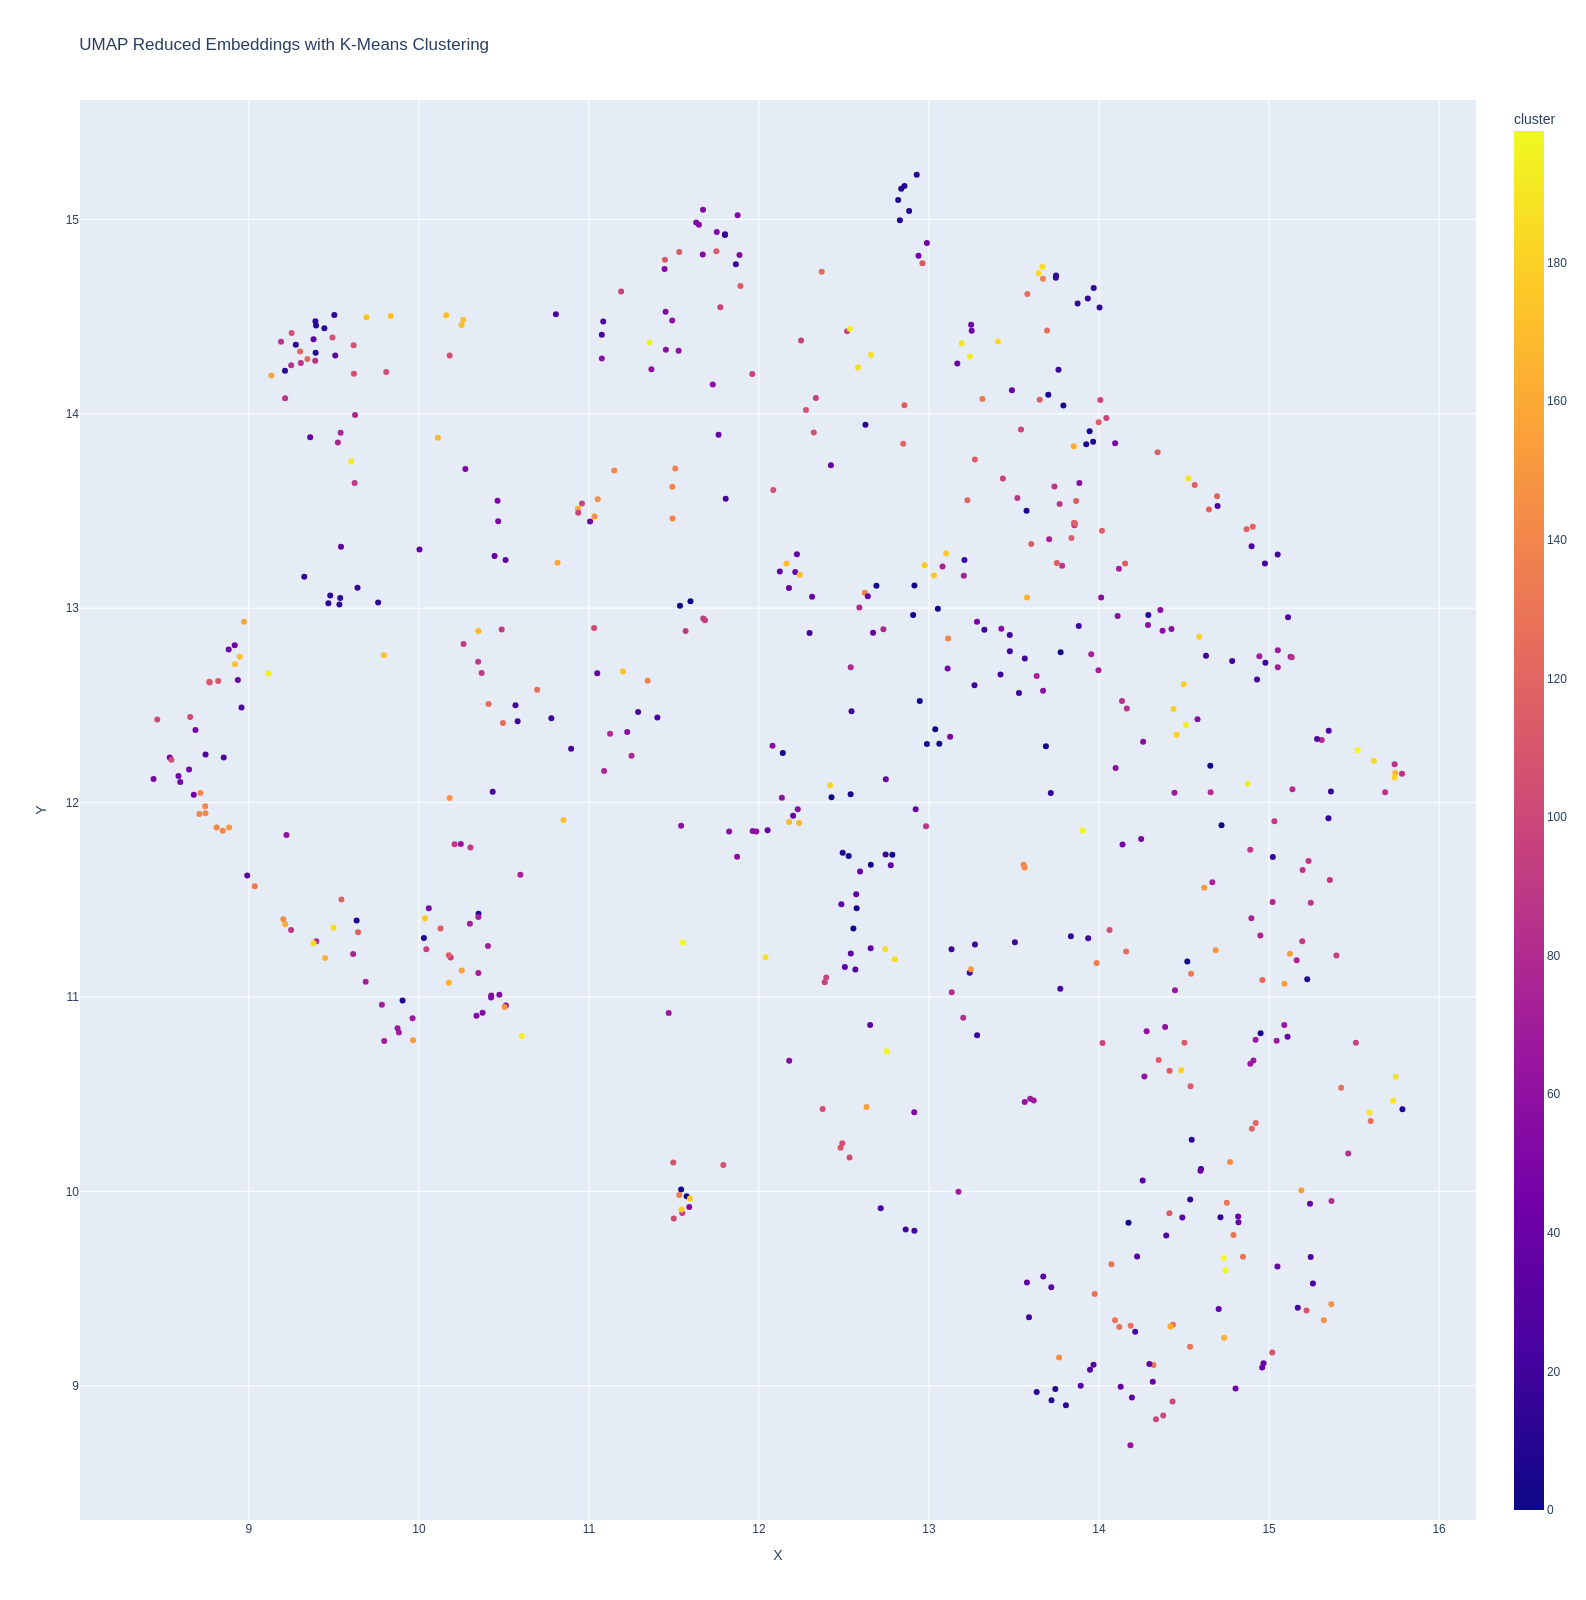

In [77]:
# Create a scatter plot with Plotly
fig = px.scatter(
    merged_df, x='X', y='Y',
    color='cluster',
    hover_data={'question': True, 'cluster': True, 'X': False, 'Y': False},
    title='UMAP Reduced Embeddings with K-Means Clustering',
    width=1600,
    height=1600,
)

# Show the plot
fig.show()

## Write sample questions and answers

In [78]:
# randomly select 1 question from each cluster, preferring questions with manual quotes
def select_one(df):
    if (df['manual quote'] != '').any():
        df = df[df['manual quote'] != '']
    return df.sample(n=1, random_state=42)

# Apply the function to each cluster group
sample_df = merged_df.groupby('cluster').apply(select_one, include_groups=False).reset_index(drop=True)
sample_df = sample_df[['url', 'question', 'answer', 'manual quote']]
print(sample_df.shape)
print(sample_df[sample_df['manual quote'] != ''].shape[0])
sample_df.head()

(200, 4)
12


,url,question,answer,manual quote
0,https://boardgamegeek.com/thread/2622592/playa...,Playable with 5 players?,"The ship actions are balanced for 1-4 players,...",
1,https://boardgamegeek.com/thread/2855483/explo...,Mac's +1 to fate to fate draw - can this be us...,"I use it for anyone participating in combat, b...",
2,https://boardgamegeek.com/thread/3250276/when-...,"And when I do a challenge using a crew member,...","Since no crew participated, damage goes to who...",
3,https://boardgamegeek.com/thread/3067118/are-y...,Are you forced to spend artifacts as coins?,I would play it that If you only have artifact...,
4,https://boardgamegeek.com/thread/2879442/a-bun...,"During a turn, can a non-turn player pay the c...",Yes,


In [79]:
sample_filename = in_filename[:-4]+'-sample.tsv'

In [80]:
# save them 
sample_df.to_csv(sample_filename, index=False, sep='\t')

In [81]:
# re-read to be sure saved
sample_df = pd.read_csv(sample_filename, sep='\t', na_filter=False)
print(sample_df.shape)
sample_df.head()

(200, 4)


,url,question,answer,manual quote
0,https://boardgamegeek.com/thread/2622592/playa...,Playable with 5 players?,"The ship actions are balanced for 1-4 players,...",
1,https://boardgamegeek.com/thread/2855483/explo...,Mac's +1 to fate to fate draw - can this be us...,"I use it for anyone participating in combat, b...",
2,https://boardgamegeek.com/thread/3250276/when-...,"And when I do a challenge using a crew member,...","Since no crew participated, damage goes to who...",
3,https://boardgamegeek.com/thread/3067118/are-y...,Are you forced to spend artifacts as coins?,I would play it that If you only have artifact...,
4,https://boardgamegeek.com/thread/2879442/a-bun...,"During a turn, can a non-turn player pay the c...",Yes,
